# Analysis of Injury Prediction Dataset

This project focuses on creating a realistic representation of player health and injury data. The synthetic dataset captures critical attributes such as player demographics, training intensities, recovery times, and previous injury histories.

The dataset was cleaned and preprocessed for ease of analysis and is available under an open license for research and data analysis purposes. The dataset is provided by a user from Kaggle (https://www.kaggle.com/datasets/mrsimple07/injury-prediction-dataset). We will be using Python to analyze the dataset and a series of visualisations such as pandas, seaborn, matplotlib and SciPy libraries to answer the following questions:

1. Does age increase the likelihood of an injury?
2. Are the difference between previous injuries and likelihood of injuries significant?
3. How do previous injuries affect recovery time?
4. Are players with high intensity training more likely to have further injuries?

## Import Libraries

In [213]:
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from matplotlib import pyplot as plt 
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

injury = pd.read_csv('injury_data.csv')

## Load and Inspect Data

In [214]:
injury.info()
injury.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player_Age            1000 non-null   int64  
 1   Player_Weight         1000 non-null   float64
 2   Player_Height         1000 non-null   float64
 3   Previous_Injuries     1000 non-null   int64  
 4   Training_Intensity    1000 non-null   float64
 5   Recovery_Time         1000 non-null   int64  
 6   Likelihood_of_Injury  1000 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 54.8 KB


,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
0,24,66.251933,175.732429,1,0.457929,5,0
1,37,70.996271,174.581650,0,0.226522,6,1
2,32,80.093781,186.329618,0,0.613970,2,1
3,28,87.473271,175.504240,1,0.252858,4,1
4,25,84.659220,190.175012,0,0.577632,1,1


The dataset contains 1000 rows and 7 columns containing information on sports athletes. Fortunately, it seems that none of the columns have any null values.

Here's a quick summary of the columns:

- **Player_Age**: Age of the player in years.
- **Player_Weight**: Weight of the player in kilograms, following a normal distribution.
- **Player_Height**: Height of the player in centimeters, following a normal distribution.
- **Previous_Injuries**: Binary indicator (0 or 1) representing whether the player has had previous injuries (1) or not (0).
- **Training_Intensity**: A value between 0 and 1 representing the intensity of the player's training regimen.
- **Recovery_Time**: Number of days required for the player to recover from an injury, ranging from 1 to 6 days.
- **Likelihood_of_Injury**: Binary indicator (0 or 1) representing the likelihood of the player experiencing an injury (1) or not (0).

In [215]:
injury.describe(include = 'all')

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,28.231000,74.794351,179.750948,0.515000,0.490538,3.466000,0.50000
std,6.538378,9.892621,9.888921,0.500025,0.286184,1.701099,0.50025
min,18.000000,40.191912,145.285701,0.000000,0.000031,1.000000,0.00000
25%,22.000000,67.944028,173.036976,0.000000,0.241042,2.000000,0.00000
50%,28.000000,75.020569,180.034436,1.000000,0.483912,4.000000,0.50000
75%,34.000000,81.302956,186.557913,1.000000,0.730404,5.000000,1.00000
max,39.000000,104.650104,207.308672,1.000000,0.997749,6.000000,1.00000


## Data Cleaning and Preparation

First, we will rename the columns 'Player_Age', 'Player_Weight' and 'Player_Height' for easier referencing. 

In [216]:
injury.rename(columns = {'Player_Age':'Age', 'Player_Weight':'Weight', 'Player_Height':'Height'}, inplace = True)

Then, we will round of the numerical values in the columns to 3 decimal places. We will also convert the values in the 'Training_Intensity' column into percentage as it is a better metric for intensity.

In [217]:
# Cleaning data
def clean_df_text(df):
    for column in df.columns:
        if df[column].dtype == 'float64':
            df[column] = df[column].round(3)      
    return df

injury['Training_Intensity'] = injury['Training_Intensity']*100

The values in the 'Previous_Injuries' and 'Likelihood_of_Injury' column are replaced with 'Yes' and 'No' for easier understanding. 

In [218]:
injury.Previous_Injuries.replace(1, 'Yes', inplace = True)
injury.Previous_Injuries.replace(0, 'No', inplace = True)
injury.Likelihood_of_Injury.replace(1, 'Yes', inplace = True)
injury.Likelihood_of_Injury.replace(0, 'No', inplace = True)

In [219]:
clean_df_text(injury)
injury.head()

,Age,Weight,Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
0,24,66.252,175.732,Yes,45.793,5,No
1,37,70.996,174.582,No,22.652,6,Yes
2,32,80.094,186.330,No,61.397,2,Yes
3,28,87.473,175.504,Yes,25.286,4,Yes
4,25,84.659,190.175,No,57.763,1,Yes


## Data Question 1: Does age increase the likelihood of an injury?

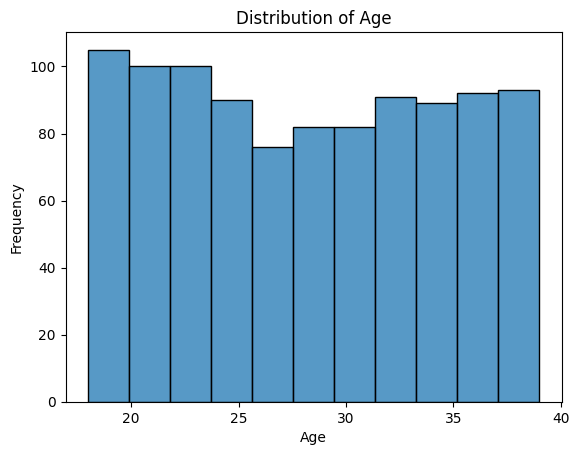

In [220]:
# Plotting distribution of Age
sns.histplot(data = injury, x = 'Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

The distribution of age in this dataset is between 18 to 39 years old. Most players are within the age group by 18 to 25. 

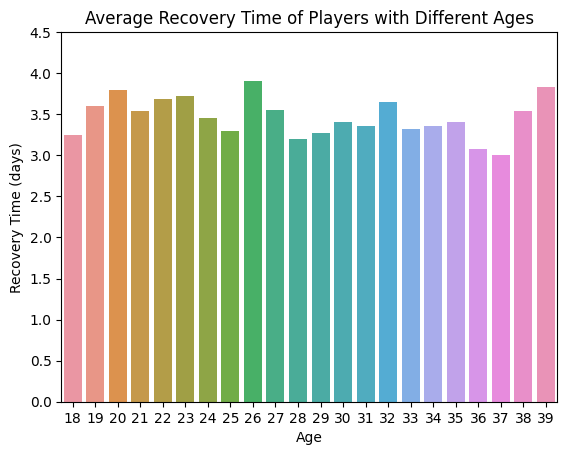

In [221]:
# Plotting bar chart for recovery time against age
sns.barplot(data = injury, x = 'Age', y = 'Recovery_Time', ci = None)
plt.title('Average Recovery Time of Players with Different Ages')
plt.ylabel('Recovery Time (days)')
plt.ylim((0,4.5))
plt.show()

The graph above does not indicate any obvious trend between age and recovery time. Recovery time seems to fluctuate on average between the ages of 18 and 39. The average recovery time peaks at two ages; 26 and 39 year old. However, this is not enough evidence to suggest that recovery time is the highest at these ages. 

## Data Question 2: Are the difference between previous injuries and likelihood of injuries significant?

This section will run a chi-squared test to see if players with and without previous injuries have statistically significant differences in the likelihood of further injuries. In order to run a chi squared test, a contingency table will need to be created. The contingency table should look like this:

||Likely of Injury|Unlikely of Injury|
|-|-|-|
|Previous Injuries|?|?|
|No Previous Injuries|?|?|

In [222]:
# Creating list for previous injury and likelihood of injury
prev_inj = [0,0]
no_prev_inj = [0,0]

for i in range(0, len(injury)):
    if injury.Previous_Injuries[i] == 'Yes' and injury.Likelihood_of_Injury[i] == 'Yes':
        prev_inj[0] += 1
    elif injury.Previous_Injuries[i] == 'Yes' and injury.Likelihood_of_Injury[i] == 'No':
        prev_inj[1] += 1
    elif injury.Previous_Injuries[i] == 'No' and injury.Likelihood_of_Injury[i] == 'Yes':
        no_prev_inj[0] += 1
    elif injury.Previous_Injuries[i] == 'No' and injury.Likelihood_of_Injury[i] == 'No':
        no_prev_inj[1] += 1

In [223]:
# Performing chi2_contingency
contingency2 = [prev_inj,
               no_prev_inj]
chi2_contingency(contingency2)

Chi2ContingencyResult(statistic=1.297167450705635, pvalue=0.2547312702283598, dof=1, expected_freq=array([[257.5, 257.5],
       [242.5, 242.5]]))

The results from the chi-squared test returns many values, the second value which is 0.254 is the p-value. The standard p-value to test statistical significance is 0.05. For the value retrieved from this test, the value of 0.254 is larger than 0.05. In the case of previous injuries and likelihood of injury, there doesn't seem to be any significant relationship between them i.e. the variables independent. This means that we can accept the null hypothesis which states that 'players with previous injuries are not likely to have further injuries'.

## Data Question 3: How do previous injuries affect recovery time?

In [224]:
# Dataframe for previous injuries and no previous injuries
prev_inj = injury[injury['Previous_Injuries'] ==  'Yes'].Recovery_Time.value_counts().reset_index(name = 'Count')
no_prev_inj = injury[injury['Previous_Injuries'] ==  'No'].Recovery_Time.value_counts().reset_index(name = 'Count')

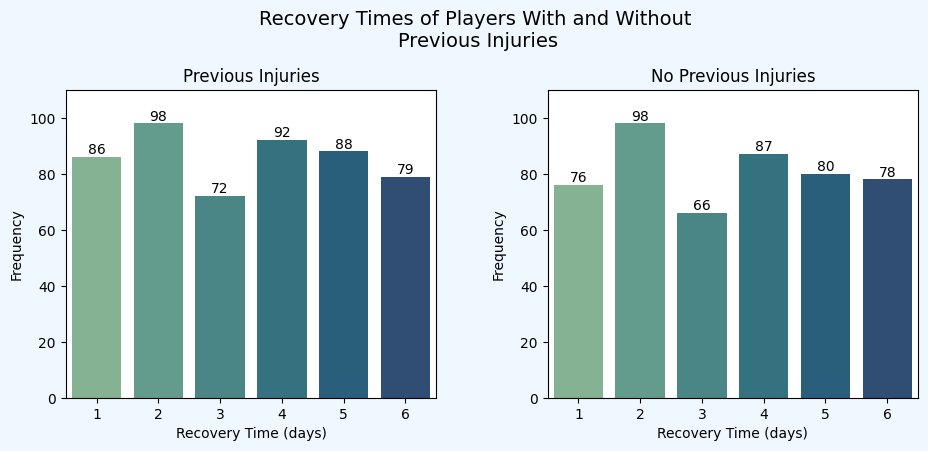

In [225]:
# Plotting bar charts for previous injuries and no previous injuries
fig = plt.figure(facecolor = 'aliceblue', figsize = (11, 4))
fig.suptitle("Recovery Times of Players With and Without \nPrevious Injuries", fontsize = 14, y = 1.08)
plt.subplots_adjust(wspace=0.3, hspace=0.6)

plt.subplot(1,2,1)
ax1 = sns.barplot(data = prev_inj, y = 'Count', x = 'Recovery_Time', palette = sns.color_palette("crest"))
plt.title('Previous Injuries')
plt.xlabel('Recovery Time (days)')
plt.ylabel('Frequency')
plt.ylim(0, 110)
ax1.bar_label(ax1.containers[0])

plt.subplot(1,2,2)
ax2 = sns.barplot(data = no_prev_inj, y = 'Count', x = 'Recovery_Time', palette = sns.color_palette("crest"))
plt.title('No Previous Injuries')
plt.xlabel('Recovery Time (days)')
plt.ylabel('Frequency')
plt.ylim(0, 110)
ax2.bar_label(ax2.containers[0])
plt.show()

For players with and without previous injuries, the trend seems to be the same. Majority of players will recover in 2 days regardless of previous injuries. However, if they do not recover within that time period, it will take them at least 4 days to 6 days. Both graphs indicate that players are less likely recovery in 3 days regardless of previous injuries. 

## Data Question 4: Are players with high intensity training more likely to have further injuries?

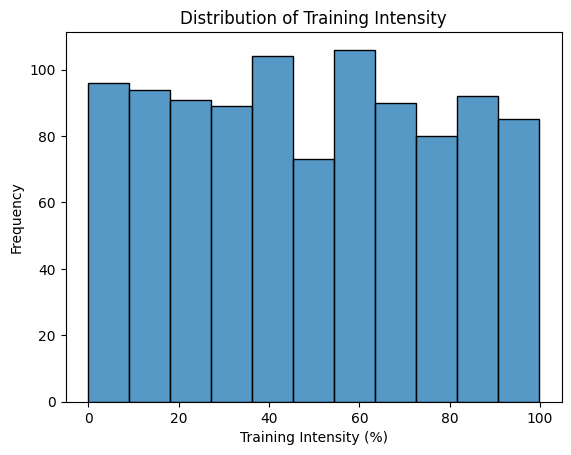

In [226]:
# Plotting distribution of training intensity
sns.histplot(data = injury, x = 'Training_Intensity')
plt.title('Distribution of Training Intensity')
plt.xlabel('Training Intensity (%)')
plt.ylabel('Frequency')
plt.show()

The distribution graph for training intensity peaks at 40% and 60% at around 120 players each. Training intensity tends to decrease in numbers from 0 to 30%. Around 70 to 90%, it fluctuates between 80 to 90 players.

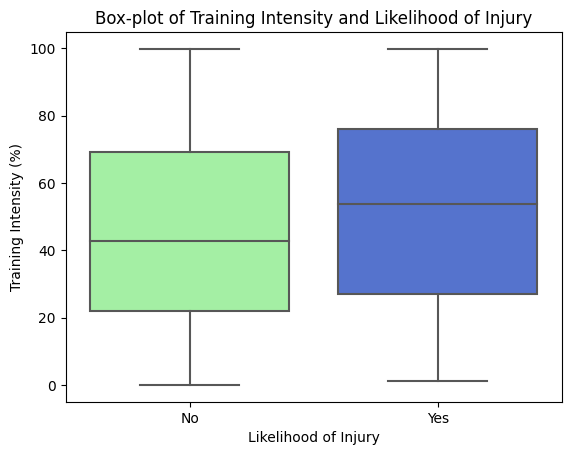

In [227]:
sns.boxplot(data = injury, x = 'Likelihood_of_Injury', y = 'Training_Intensity', palette= {'Yes':'royalblue', 'No':'palegreen'})
plt.title('Box-plot of Training Intensity and Likelihood of Injury')
plt.xlabel('Likelihood of Injury')
plt.ylabel('Training Intensity (%)')
plt.show()

Players that are more likely to have further injury seem to have a higher average training intensity, approximately 58% compared to players that are less likely to injure (~42%). The upper quartile and lower quartile of players with a likelihood of injury is also higher. This indicates that an increase in training intensity could potentially lead to further injuries. However, the difference in training intensity is not significant.

## Conclusion 

This project highlights the different factors of players that could affect their recovery time and the likelihood of injuries. It was found that there is no significant correlation between age and recover time, between ages of 18 and 39. It was also found that the relationship between previous injuries and likelihood of further injury is not significantly different which means that players with a previous injury does not increase the likelihood of injury. Another finding was that most players with injuries recover in 2 days or within 4 to 6 days regardless of any prior injuries. Lastly, it was demonstrated that players that perform higher intensity training on average (~58%) are more likely to injure. 